In [6]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report


In [12]:

# 2. Load dataset
file_path = 'Anand_Gopalakrishnamurthy_loan_data.xlsx'
df = pd.read_excel(file_path)


In [14]:
# 3. Encode categorical variables
data = df.copy()
label_encoders = {}
categorical_cols = data.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le



In [16]:
# 4. Define features and target
X = data.drop('loan_status', axis=1)
y = data['loan_status']


In [18]:

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)



In [20]:
# 6. Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [22]:
# 7. Train models
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)
log_probs = log_model.predict_proba(X_test_scaled)[:, 1]

tree_model = DecisionTreeClassifier(max_depth=5, class_weight='balanced', random_state=42)
tree_model.fit(X_train, y_train)
tree_probs = tree_model.predict_proba(X_test)[:, 1]


In [24]:

# 8. Evaluate models
print("Logistic Regression AUC:", roc_auc_score(y_test, log_probs))
print("Decision Tree AUC:", roc_auc_score(y_test, tree_probs))

print("\nLogistic Regression Report:")
print(classification_report(y_test, (log_probs > 0.5).astype(int)))

print("\nDecision Tree Report:")
print(classification_report(y_test, (tree_probs > 0.5).astype(int)))



Logistic Regression AUC: 0.9427685000000001
Decision Tree AUC: 0.9475508214285714

Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7000
           1       0.77      0.72      0.74      2000

    accuracy                           0.89      9000
   macro avg       0.85      0.83      0.84      9000
weighted avg       0.89      0.89      0.89      9000


Decision Tree Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      7000
           1       0.71      0.81      0.76      2000

    accuracy                           0.88      9000
   macro avg       0.83      0.86      0.84      9000
weighted avg       0.89      0.88      0.89      9000



In [26]:
# 9. Prepare data for Tableau export
tableau_data = X_test.copy()
tableau_data['actual_loan_status'] = y_test.values
tableau_data['logistic_prob'] = log_probs
tableau_data['tree_prob'] = tree_probs
tableau_data['logistic_pred'] = (log_probs > 0.5).astype(int)
tableau_data['tree_pred'] = (tree_probs > 0.5).astype(int)


In [28]:

# Save to CSV
tableau_data.to_csv('loan_risk_model_results.csv', index=False)



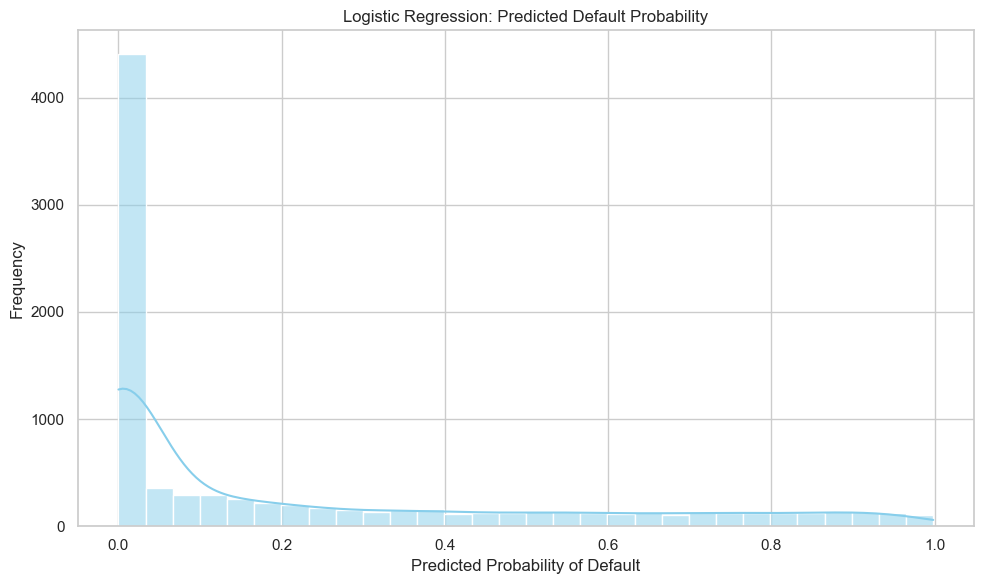

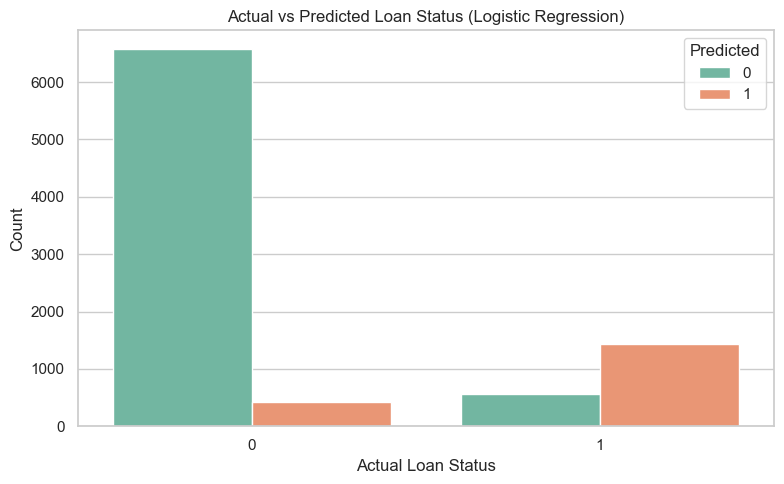

/var/folders/ql/sv88m48x39vfj16x9jzlt05w0000gn/T/ipykernel_4048/385303369.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')


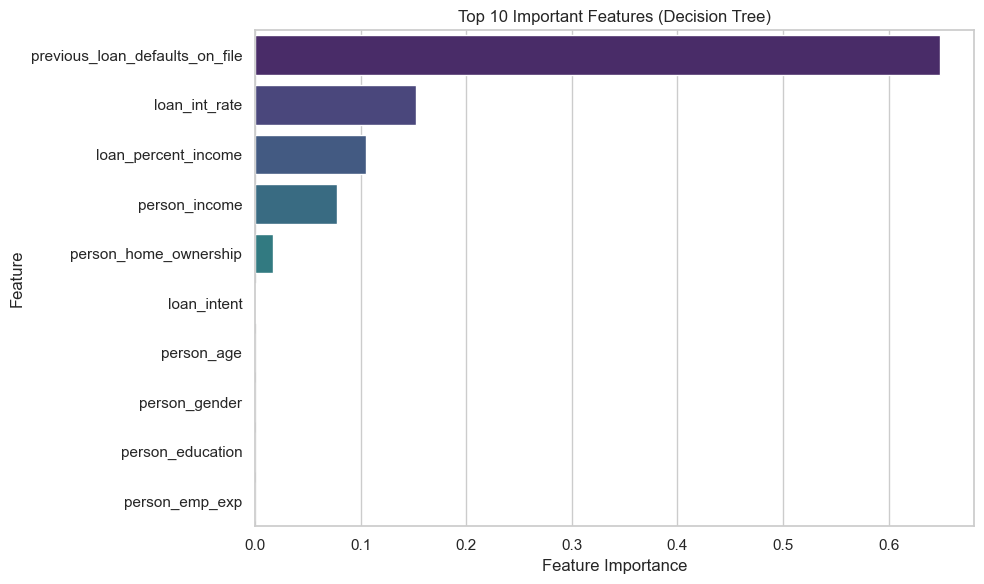

In [30]:
# 10. Visualization
sns.set(style="whitegrid")

# A. Predicted probability distribution
plt.figure(figsize=(10, 6))
sns.histplot(tableau_data['logistic_prob'], bins=30, kde=True, color='skyblue')
plt.title('Logistic Regression: Predicted Default Probability')
plt.xlabel('Predicted Probability of Default')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# B. Actual vs Predicted
plt.figure(figsize=(8, 5))
sns.countplot(x='actual_loan_status', hue='logistic_pred', data=tableau_data, palette='Set2')
plt.title('Actual vs Predicted Loan Status (Logistic Regression)')
plt.xlabel('Actual Loan Status')
plt.ylabel('Count')
plt.legend(title='Predicted')
plt.tight_layout()
plt.show()

# C. Feature Importance (Decision Tree)
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Top 10 Important Features (Decision Tree)')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()